## autoencoder + transformer to handle spatial and temporal information

### draft scripts

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        
        if upsample:
            self.upsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.upsample:
            identity = self.upsample_layer(x)
        
        out += identity
        out = self.relu(out)
        
        return out
    
class Encoder(nn.Module):
    def __init__(self, num_channels=3):
        super(Encoder, self).__init__()
        self.encoder = models.resnet18(weights=None)
        self.encoder.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)  
        self.encoder.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, num_channels=3):
        super(Decoder, self).__init__()
        self.decoder_linear = nn.Linear(512, 512 * 7 * 7)  # Upsample to 7x7 feature map

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_channels, kernel_size=4, stride=2, padding=1),  # 56x56 -> 112x112
            nn.Sigmoid()
        )

    def forward(self, feature_vectors, target_size):
        batch_size = feature_vectors.size(0)
        h = self.decoder_linear(feature_vectors).view(batch_size, 512, 7, 7)
        h = self.decoder(h)
        
        # Final interpolation to match the target size
        h = F.interpolate(h, size=(target_size[2], target_size[3]), mode='bilinear', align_corners=False)
        return h

class autoencoder(nn.Module):
    def __init__(self, num_channels=3):
        super(autoencoder, self).__init__()
        
        # Encoder (ResNet18)
        self.encoder = Encoder(num_channels)

        # Decoder
        self.decoder = Decoder(num_channels)

    def forward(self, x):
        outputs = self.encoder(x)
        outputs = self.decoder(outputs, x.size())
        return outputs


encoder = Encoder(num_channels=1)
decoder = Decoder(num_channels=1)
inputs = torch.randn(2, 1, 250, 400)
features = encoder(inputs)
print('feature vectors:', features.shape)

reconstructed = decoder(features, inputs.size())
print('reconstructed:', reconstructed.shape)

model = autoencoder(num_channels=1)
output = model(inputs)
print('output:', output.shape)

feature vectors: torch.Size([2, 512])
reconstructed: torch.Size([2, 1, 250, 400])
output: torch.Size([2, 1, 250, 400])


In [7]:
class VideoRegressionModel(nn.Module):
    def __init__(self, num_frames, num_channels, hidden_dim, num_layers, num_heads, mlp_dim, output_dim):
        super(VideoRegressionModel, self).__init__()
        self.num_frames = num_frames
        self.num_channels = num_channels

        self.encoder = Encoder(num_channels)
        self.decoder = Decoder(num_channels)

        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, 
                                          dim_feedforward=mlp_dim, dropout=0.1, activation='relu', batch_first=True)

        self.feature_projection = nn.Linear(512, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        features = []
        reconstructed_frames = []
        for i in range(self.num_frames):
            frame = x[:, i]
            frame_features = self.encoder(frame)
            
            # Project features to match transformer input dimension
            projected_features = self.feature_projection(frame_features)
            
            reconstructed_frame = self.decoder(frame_features, frame.size())
            features.append(projected_features)
            reconstructed_frames.append(reconstructed_frame)
        
        features = torch.stack(features, dim=1)
        reconstructed_video = torch.stack(reconstructed_frames, dim=1)

        outputs = self.transformer(features, features)
        outputs = outputs.mean(dim=1) 
        regression_output = self.fc(outputs)
        
        return regression_output, reconstructed_video

# Example usage
model = VideoRegressionModel(num_frames=24, num_channels=1, hidden_dim=512, 
                             num_layers=4, num_heads=8, mlp_dim=2048, output_dim=1)

# Test with a sample input
input_data = torch.randn(2, 24, 1, 250, 400)  # Batch size 2, 24 frames, 3 channels, 224x224 resolution
target = torch.randn(2, 1)  # Batch size 2, 1 output value

output, reconstructed_video = model(input_data)
print(f"Input shape: {input_data.shape}")
print(f"Output shape: {output.shape}")
print(f"Reconstructed video shape: {reconstructed_video.shape}")

### packed function for training

In [6]:
import h5py
import os
import time
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision import datasets, transforms, models
import matplotlib.image as image

import sys
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/utils')
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/benchmark')
from utils import split_train_valid, viz_dataloader
from viz import show_images

class hdf5_dataset(Dataset):
    
    def __init__(self, file_path, folder=None, transform=None, data_key='data', label_key='labels'):
        self.file_path = file_path
        self.folder = folder
        self.transform = transform
        self.hf = None
        self.data_key = data_key
        self.label_key = label_key

    def __len__(self):
        with h5py.File(self.file_path, 'r') as f:
            if self.folder:
                self.len = len(f[self.folder][self.label_key])
            else:
                self.len = len(f[self.label_key])
        return self.len
    
    def __getitem__(self, idx):
        if self.hf is None:
            self.hf = h5py.File(self.file_path, 'r')
        
        if self.folder:
            video = np.array(self.hf[self.folder][self.data_key][idx])
            label = np.array(self.hf[self.folder][self.label_key][idx])
        else:
            video = np.array(self.hf[self.data_key][idx])
            label = np.array(self.hf[self.label_key][idx])
            
        # Convert numpy array to a list of PIL Images
        if video.dtype != np.uint8:
            video = (video * 255).astype(np.uint8)
        
        video_frames = []
        for frame in video:
            if frame.ndim == 2:  # If it's a grayscale image
                frame = Image.fromarray(frame, mode='L')
            else:
                frame = Image.fromarray(frame)
            video_frames.append(frame)
        
        if self.transform:
            video_frames = [self.transform(frame) for frame in video_frames]
            video_frames = torch.stack(video_frames)
            # Remove the following line to keep the shape as [128, 250, 400]
            if video_frames.ndim == 3:
                video_frames = video_frames.unsqueeze(1)  # expand dimension for single channel video
            # video_frames = video_frames.squeeze()  # expand dimension for single channel video

        return video_frames, torch.tensor(label)


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        
        if upsample:
            self.upsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.upsample:
            identity = self.upsample_layer(x)
        
        out += identity
        out = self.relu(out)
        
        return out
    
class Encoder(nn.Module):
    def __init__(self, num_channels=3):
        super(Encoder, self).__init__()
        self.encoder = models.resnet18(weights=None)
        self.encoder.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)  
        self.encoder.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, num_channels=3):
        super(Decoder, self).__init__()
        self.decoder_linear = nn.Linear(512, 512 * 7 * 7)  # Upsample to 7x7 feature map

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_channels, kernel_size=4, stride=2, padding=1),  # 56x56 -> 112x112
            nn.Sigmoid()
        )

    def forward(self, feature_vectors, target_size):
        batch_size = feature_vectors.size(0)
        h = self.decoder_linear(feature_vectors).view(batch_size, 512, 7, 7)
        h = self.decoder(h)
        
        # Final interpolation to match the target size
        h = F.interpolate(h, size=(target_size[2], target_size[3]), mode='bilinear', align_corners=False)
        return h


class VideoRegressionModel(nn.Module):
    def __init__(self, num_frames, num_channels, hidden_dim, num_layers, num_heads, mlp_dim, output_dim):
        super(VideoRegressionModel, self).__init__()
        self.num_frames = num_frames
        self.num_channels = num_channels

        self.encoder = Encoder(num_channels)
        self.decoder = Decoder(num_channels)

        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, 
                                          dim_feedforward=mlp_dim, dropout=0.1, activation='relu', batch_first=True)

        self.feature_projection = nn.Linear(512, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        features = []
        reconstructed_frames = []
        for i in range(self.num_frames):
            frame = x[:, i]
            frame_features = self.encoder(frame)
            
            # Project features to match transformer input dimension
            projected_features = self.feature_projection(frame_features)
            
            reconstructed_frame = self.decoder(frame_features, frame.size())
            features.append(projected_features)
            reconstructed_frames.append(reconstructed_frame)
        
        features = torch.stack(features, dim=1)
        reconstructed_video = torch.stack(reconstructed_frames, dim=1)

        outputs = self.transformer(features, features)
        outputs = outputs.mean(dim=1) 
        regression_output = self.fc(outputs)
        
        return regression_output, reconstructed_video

# # Example usage
# model = VideoRegressionModel(num_frames=24, num_channels=1, hidden_dim=512, 
#                              num_layers=4, num_heads=8, mlp_dim=2048, output_dim=1)

# # Test with a sample input
# input_data = torch.randn(2, 24, 1, 250, 400)  # Batch size 2, 24 frames, 3 channels, 224x224 resolution
# target = torch.randn(2, 1)  # Batch size 2, 1 output value

# output, reconstructed_video = model(input_data)
# print(f"Input shape: {input_data.shape}")
# print(f"Output shape: {output.shape}")
# print(f"Reconstructed video shape: {reconstructed_video.shape}")


bs = 8
num_workers = 4

# imagenet
train_ds = hdf5_dataset('../../../datasets/growth_rate_regression_ds_2_26frames_train.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='growth_rate(angstrom_per_pulse)')
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

valid_ds = hdf5_dataset('../../../datasets/growth_rate_regression_ds_2_26frames_test.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='growth_rate(angstrom_per_pulse)')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dl))
images, labels = batch
print(images.shape, labels.shape)

model = VideoRegressionModel(num_frames=24, num_channels=1, hidden_dim=512, 
                             num_layers=4, num_heads=8, mlp_dim=2048, output_dim=1)
# gr, reconstructed = model(torch.randn(2, 24, 1, 250, 400))
# print(gr.shape, reconstructed.shape)  # Should be (batch_size, output_dim)

torch.Size([8, 24, 1, 250, 400]) torch.Size([8, 1])


In [7]:
import torch
import os
import time
from tqdm import tqdm
from collections import defaultdict

class ModelTrainer:
    def __init__(self, model, loss_calculator, optimizer, device, scheduler=None):
        self.model = model
        self.loss_calculator = loss_calculator
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler
        self.history = defaultdict(list)

    def train_epochs(self, train_dl, valid_dl_list, valid_name_list, epochs, start=0, 
                     valid_every_epochs=1, model_dir=None, save_per_epoch=1):
        
        if isinstance(valid_every_epochs, int) and valid_dl_list:
            valid_every_epochs = [valid_every_epochs] * len(valid_dl_list)
        elif isinstance(valid_every_epochs, list) and len(valid_every_epochs) != len(valid_dl_list):
            raise ValueError("The length of valid_every_epochs should match the number of cross-validation datasets.")
        
        if model_dir and not os.path.isdir(model_dir):
            os.mkdir(model_dir)

        for epoch_idx in range(start, epochs + start):
            print(f"Epoch: {epoch_idx + 1}/{epochs + start}")
            
            train_losses = self.run_epoch(train_dl, is_training=True)
            self.print_losses("Training", train_losses)
            
            metadata = {'epoch': epoch_idx, **{f'train_{k}': v for k, v in train_losses.items()}}

            if valid_dl_list:
                for i, (cv_dl, cv_name) in enumerate(zip(valid_dl_list, valid_name_list)):
                    if (epoch_idx + 1) % valid_every_epochs[i] == 0:
                        valid_losses = self.run_epoch(cv_dl, is_training=False)
                        self.print_losses(cv_name, valid_losses)
                        metadata.update({f'{cv_name}_{k}': v for k, v in valid_losses.items()})

            if model_dir is not None and (epoch_idx + 1) % save_per_epoch == 0:
                self.save_model(os.path.join(model_dir, f'epoch-{epoch_idx + 1}.pt'))

            for key, value in metadata.items():
                self.history[key].append(value)
                
        return dict(self.history)

    def run_epoch(self, dataloader, is_training):
        epoch_losses = defaultdict(float)
        self.model.train(is_training)

        with torch.set_grad_enabled(is_training):
            for batch in tqdm(dataloader):
                batch_losses = self.run_batch(batch, is_training)
                for k, v in batch_losses.items():
                    epoch_losses[k] += v

        return {k: v / len(dataloader.dataset) for k, v in epoch_losses.items()}

    def run_batch(self, batch, is_training):
        # print(batch[0].dtype, batch[1].dtype)
        inputs, labels = [t.to(self.device).float() for t in batch]
        # print(inputs.dtype, labels.dtype)
        self.model = self.model.to(self.device)

        if is_training:
            self.optimizer.zero_grad()

        outputs = self.model(inputs)
        losses = self.loss_calculator(outputs, inputs, labels)

        if is_training:
            losses['Total_loss'].backward()
            self.optimizer.step()
            if self.scheduler:
                self.scheduler.step()

        return losses

    def print_losses(self, phase, losses):
        print(f"{phase}:")
        for k, v in losses.items():
            print(f"  {k}: {v:.4f}")

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))

    def get_history(self):
        return dict(self.history)

In [3]:
device = torch.device('cuda:6')
lr = 1e-5
start = 0
epochs = 200

def custom_loss_calculator(outputs, inputs, labels):
    losses = {}
    predictions, reconstructed = outputs

    loss_growth_rate = F.mse_loss(predictions, labels)
    loss_reconstruction = F.mse_loss(reconstructed, inputs)
    losses['loss_growth_rate'] = loss_growth_rate.item()
    losses['loss_reconstruction'] = loss_reconstruction.item()

    total_loss = loss_growth_rate + loss_reconstruction
    losses['Total_loss'] = total_loss

    return losses

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))

trainer = ModelTrainer(model, custom_loss_calculator, optimizer, device, scheduler)
history = trainer.train_epochs(train_dl, valid_dl_list=[valid_dl], valid_name_list=['validation'], epochs=epochs, model_dir='../../../datasets/growth_rate_ae_transformer_a100_lr1e-5/')

# history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl_list=[valid_dl], valid_name_list=['validation'],
#                        epochs=epochs, start=start, scheduler=scheduler, valid_every_epochs=1, save_per_epoch=10,
#                        model_dir='../../../datasets/growth_rate_regression/', tracking=False)

Epoch: 1/200


  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [01:11<00:00,  1.71s/it]


Training:
  loss_growth_rate: 0.0019
  loss_reconstruction: 0.0030
  Total_loss: 0.0048


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


validation:
  loss_growth_rate: 0.0010
  loss_reconstruction: 0.0031
  Total_loss: 0.0041
Epoch: 2/200


100%|██████████| 42/42 [01:07<00:00,  1.61s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0030
  Total_loss: 0.0032


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0031
  Total_loss: 0.0031
Epoch: 3/200


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0030
  Total_loss: 0.0031


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0031
  Total_loss: 0.0031
Epoch: 4/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0030
  Total_loss: 0.0031


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0031
  Total_loss: 0.0031
Epoch: 5/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0030
  Total_loss: 0.0031


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0031
  Total_loss: 0.0031
Epoch: 6/200


100%|██████████| 42/42 [01:05<00:00,  1.57s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0029
  Total_loss: 0.0031


100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0031
  Total_loss: 0.0031
Epoch: 7/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0029
  Total_loss: 0.0030


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0031
  Total_loss: 0.0031
Epoch: 8/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0029
  Total_loss: 0.0030


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0030
  Total_loss: 0.0030
Epoch: 9/200


100%|██████████| 42/42 [01:08<00:00,  1.63s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0029
  Total_loss: 0.0030


100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0030
  Total_loss: 0.0030
Epoch: 10/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0029
  Total_loss: 0.0030


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0030
  Total_loss: 0.0030
Epoch: 11/200


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0028
  Total_loss: 0.0029


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0029
  Total_loss: 0.0029
Epoch: 12/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0028
  Total_loss: 0.0029


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0028
  Total_loss: 0.0028
Epoch: 13/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0027
  Total_loss: 0.0028


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0025
  Total_loss: 0.0025
Epoch: 14/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0024
  Total_loss: 0.0025


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0022
  Total_loss: 0.0022
Epoch: 15/200


100%|██████████| 42/42 [01:10<00:00,  1.68s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0020
  Total_loss: 0.0020


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0016
  Total_loss: 0.0016
Epoch: 16/200


100%|██████████| 42/42 [01:10<00:00,  1.68s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0014
  Total_loss: 0.0015


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0012
  Total_loss: 0.0012
Epoch: 17/200


100%|██████████| 42/42 [01:09<00:00,  1.64s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0010
  Total_loss: 0.0011


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0010
  Total_loss: 0.0010
Epoch: 18/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0009
  Total_loss: 0.0010


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0008
  Total_loss: 0.0009
Epoch: 19/200


100%|██████████| 42/42 [01:06<00:00,  1.59s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0008
  Total_loss: 0.0009


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0008
  Total_loss: 0.0008
Epoch: 20/200


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0007
  Total_loss: 0.0008


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0007
  Total_loss: 0.0007
Epoch: 21/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0007
  Total_loss: 0.0008


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0006
  Total_loss: 0.0007
Epoch: 22/200


100%|██████████| 42/42 [01:07<00:00,  1.61s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0007
  Total_loss: 0.0007


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0006
  Total_loss: 0.0006
Epoch: 23/200


100%|██████████| 42/42 [01:08<00:00,  1.63s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0006
  Total_loss: 0.0007


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


validation:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0005
  Total_loss: 0.0006
Epoch: 24/200


100%|██████████| 42/42 [01:08<00:00,  1.63s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0006
  Total_loss: 0.0007


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


validation:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0005
  Total_loss: 0.0006
Epoch: 25/200


100%|██████████| 42/42 [01:03<00:00,  1.52s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0006
  Total_loss: 0.0006


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005
Epoch: 26/200


100%|██████████| 42/42 [01:06<00:00,  1.59s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0006
  Total_loss: 0.0006


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005
Epoch: 27/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0006
  Total_loss: 0.0006


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0005
Epoch: 28/200


100%|██████████| 42/42 [01:06<00:00,  1.59s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0006


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0005
Epoch: 29/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0006


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


validation:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0004
  Total_loss: 0.0005
Epoch: 30/200


100%|██████████| 42/42 [01:05<00:00,  1.57s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0006


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


validation:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 31/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 32/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 33/200


100%|██████████| 42/42 [01:05<00:00,  1.56s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


validation:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 34/200


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0005


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 35/200


100%|██████████| 42/42 [01:06<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 36/200


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 37/200


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 38/200


100%|██████████| 42/42 [01:06<00:00,  1.59s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 39/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0004


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0005
Epoch: 40/200


100%|██████████| 42/42 [01:03<00:00,  1.52s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0004


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 41/200


100%|██████████| 42/42 [01:04<00:00,  1.54s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0003


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0005
Epoch: 42/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0003


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


validation:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0004
  Total_loss: 0.0005
Epoch: 43/200


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0003


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0005
Epoch: 44/200


100%|██████████| 42/42 [01:06<00:00,  1.59s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0003


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005
Epoch: 45/200


100%|██████████| 42/42 [01:11<00:00,  1.70s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0003


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0006
  Total_loss: 0.0006
Epoch: 46/200


100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0003


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005
Epoch: 47/200


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0003
  Total_loss: 0.0003


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005
Epoch: 48/200


100%|██████████| 42/42 [01:05<00:00,  1.56s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0002
  Total_loss: 0.0003


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005
Epoch: 49/200


100%|██████████| 42/42 [01:08<00:00,  1.64s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0002
  Total_loss: 0.0002


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0005
  Total_loss: 0.0005
Epoch: 50/200


100%|██████████| 42/42 [01:06<00:00,  1.57s/it]


Training:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0002
  Total_loss: 0.0002


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


validation:
  loss_growth_rate: 0.0000
  loss_reconstruction: 0.0004
  Total_loss: 0.0004
Epoch: 51/200


 45%|████▌     | 19/42 [00:31<00:38,  1.67s/it]


KeyboardInterrupt: 

In [5]:
torch.save(model.cpu().state_dict(), '../../../datasets/growth_rate_ae_transformer/best_model.pt')

In [8]:
model.load_state_dict(torch.load('../../../datasets/growth_rate_ae_transformer_a100_lr1e-5/epoch-50.pt'))

<All keys matched successfully>

torch.Size([8, 1]) torch.Size([8, 1]) torch.Size([8, 24, 1, 250, 400]) torch.Size([8, 24, 1, 250, 400])


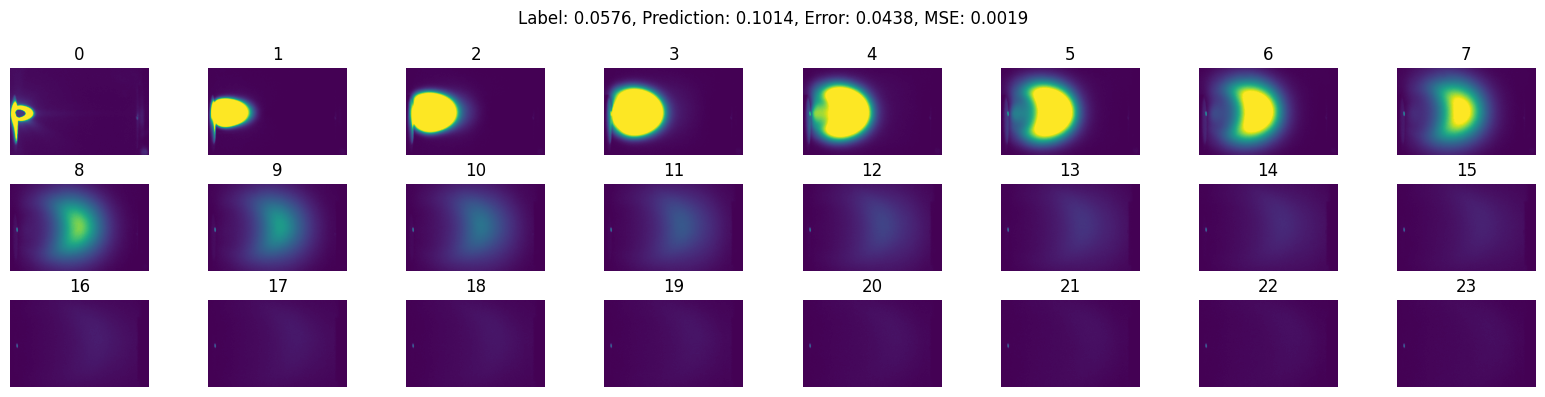

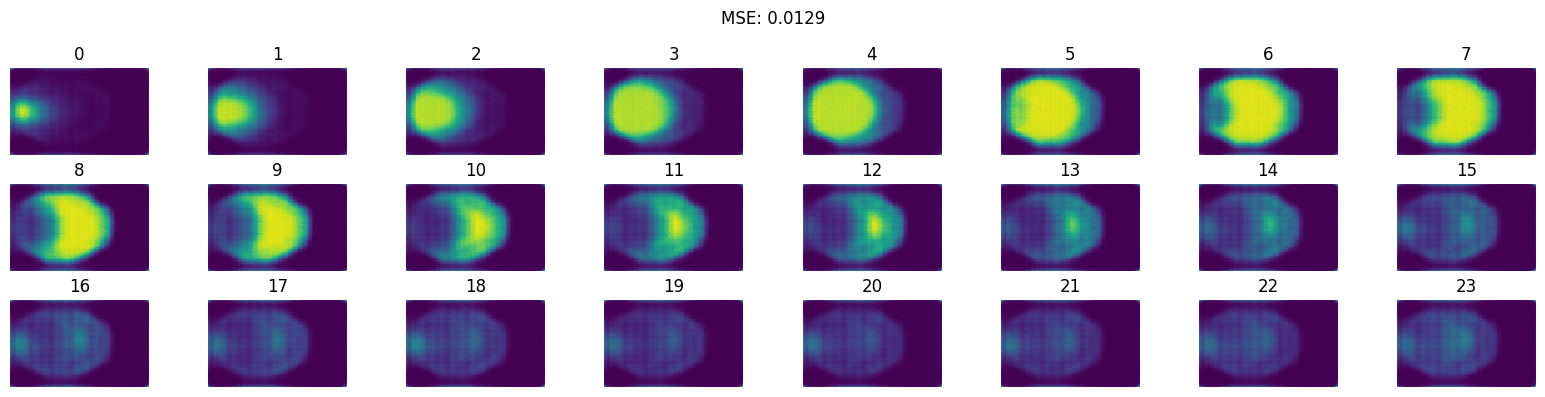

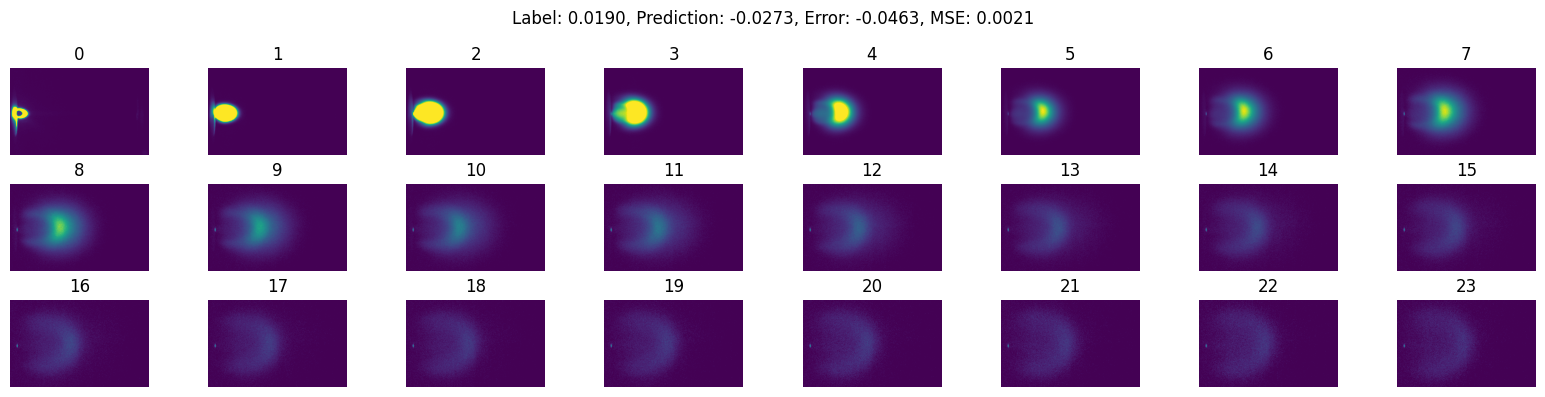

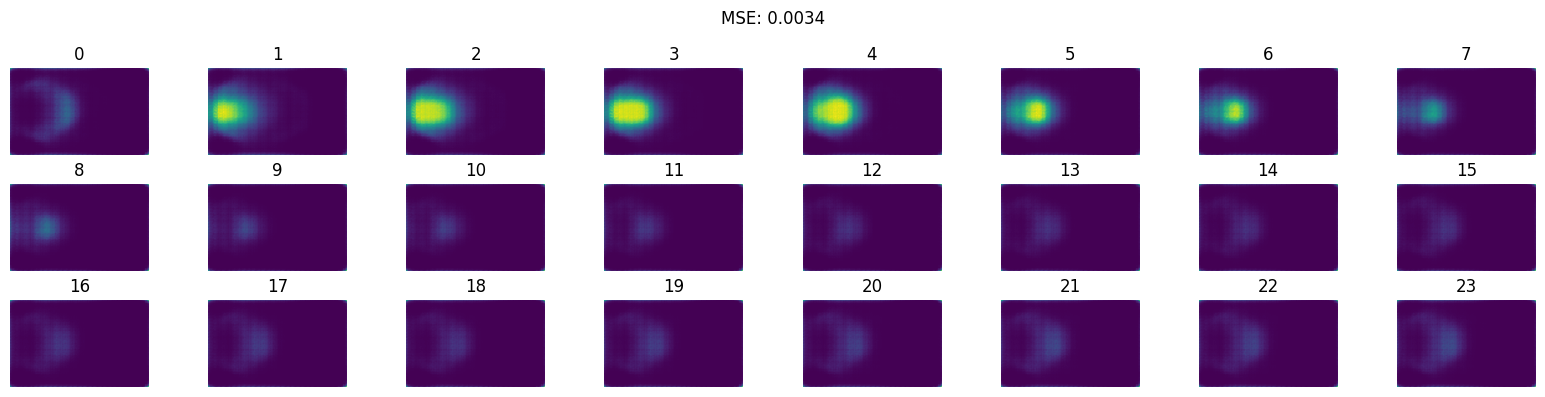

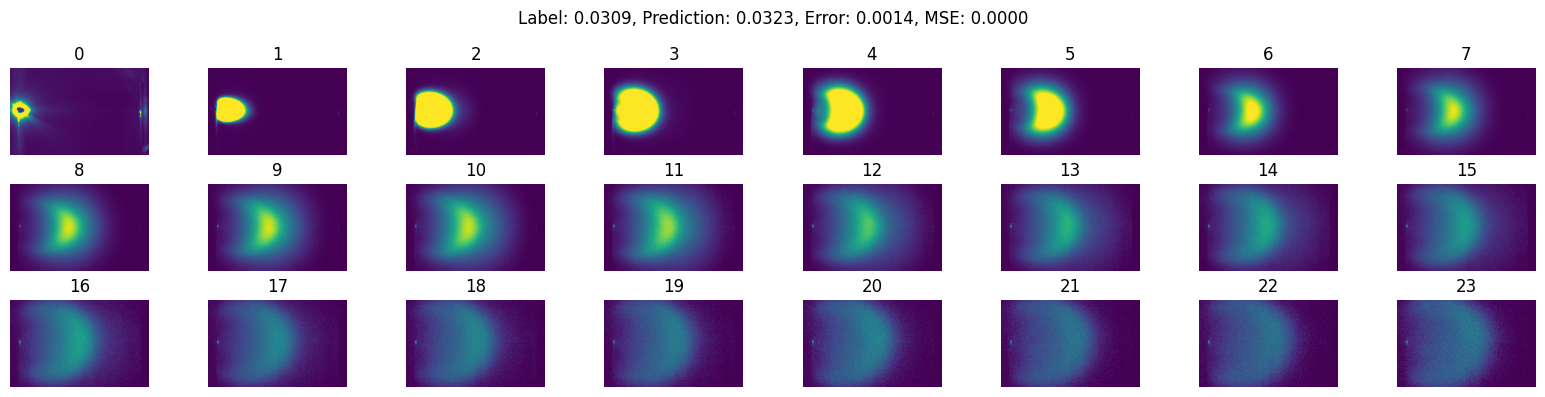

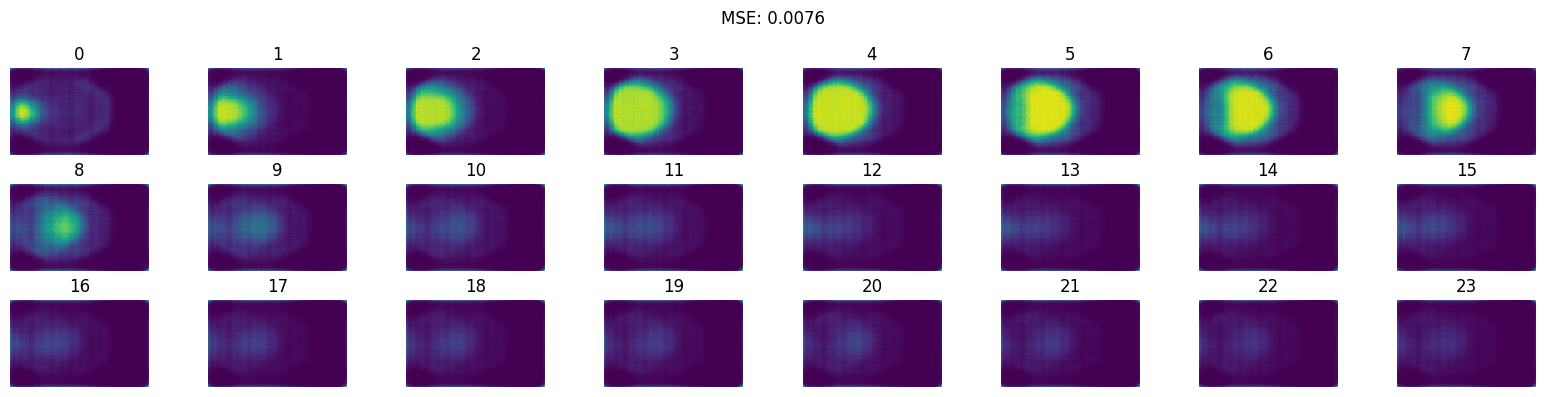

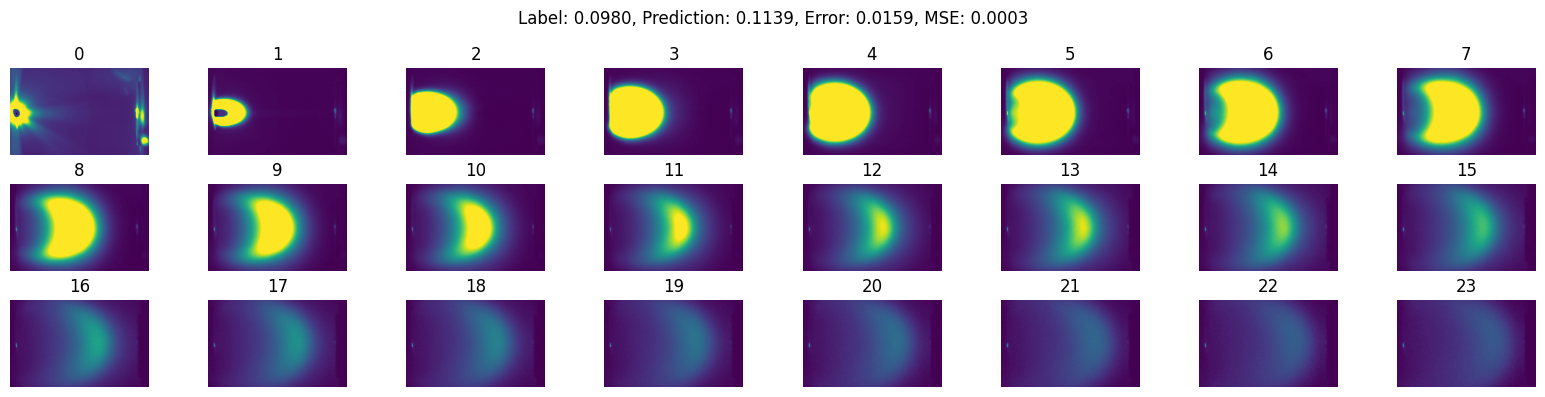

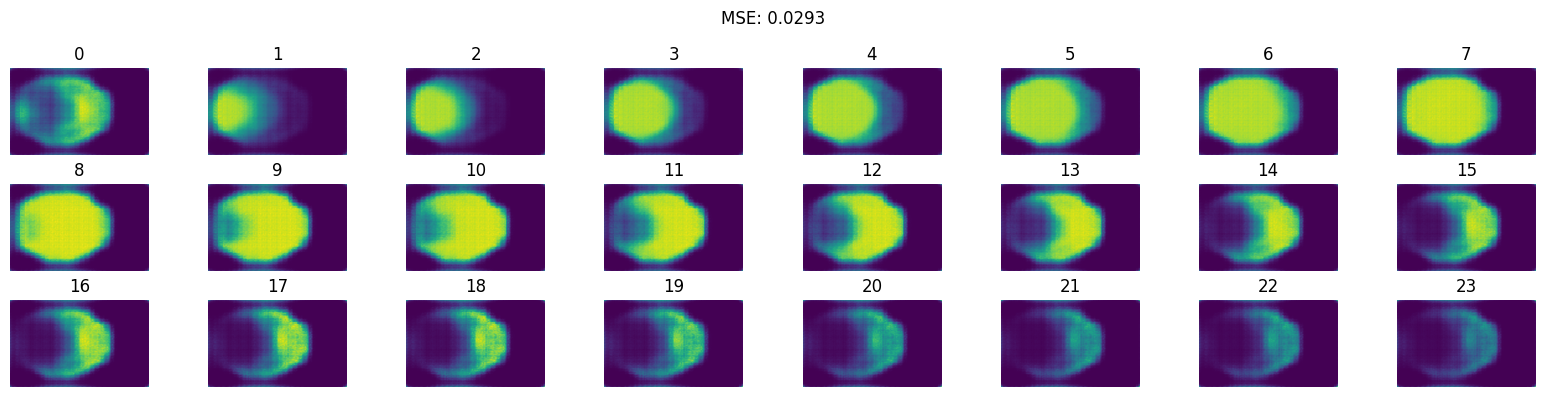

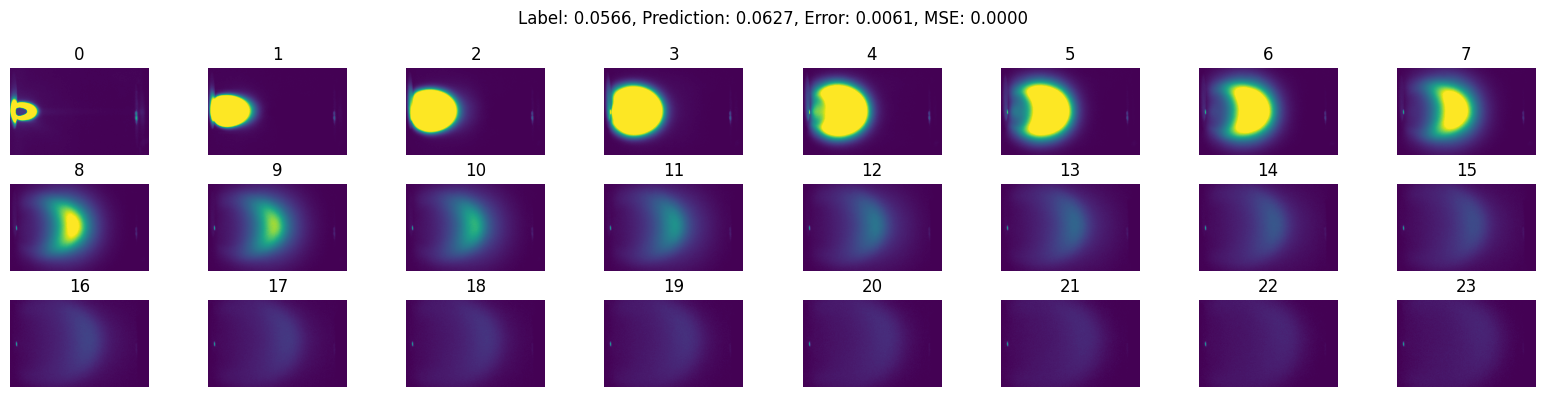

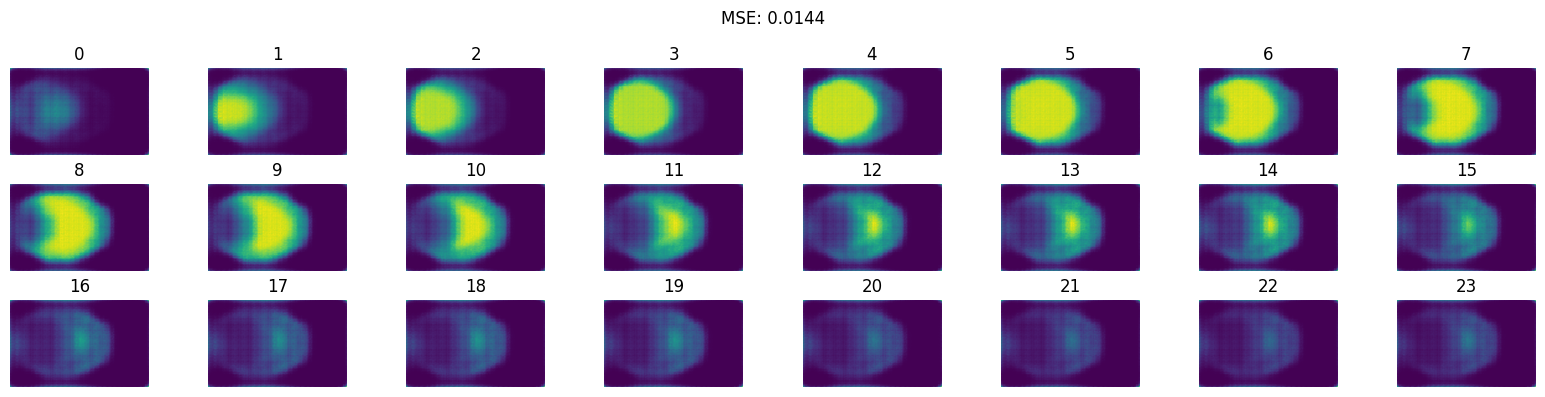

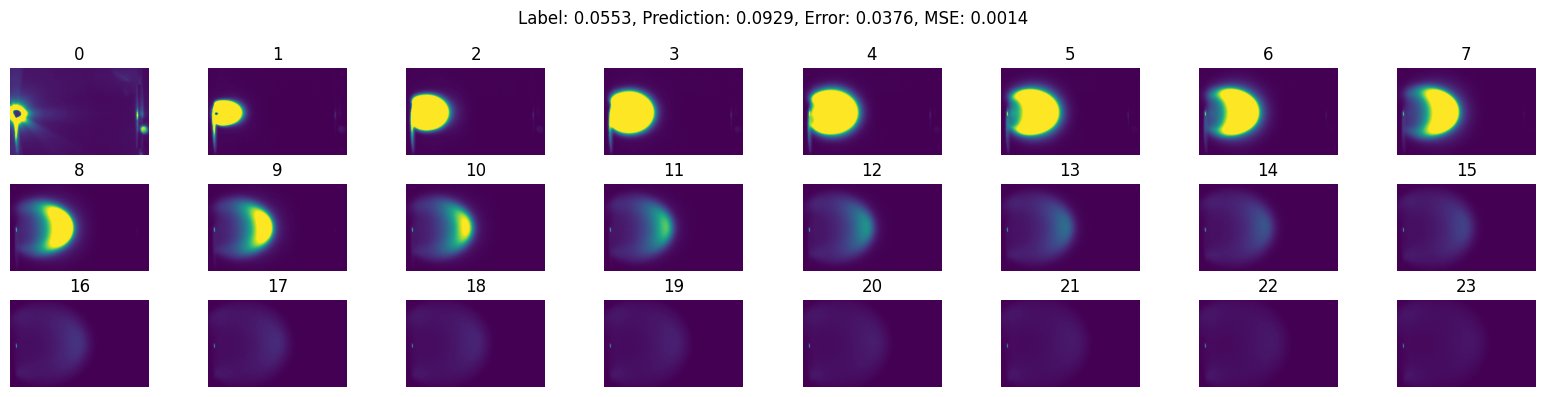

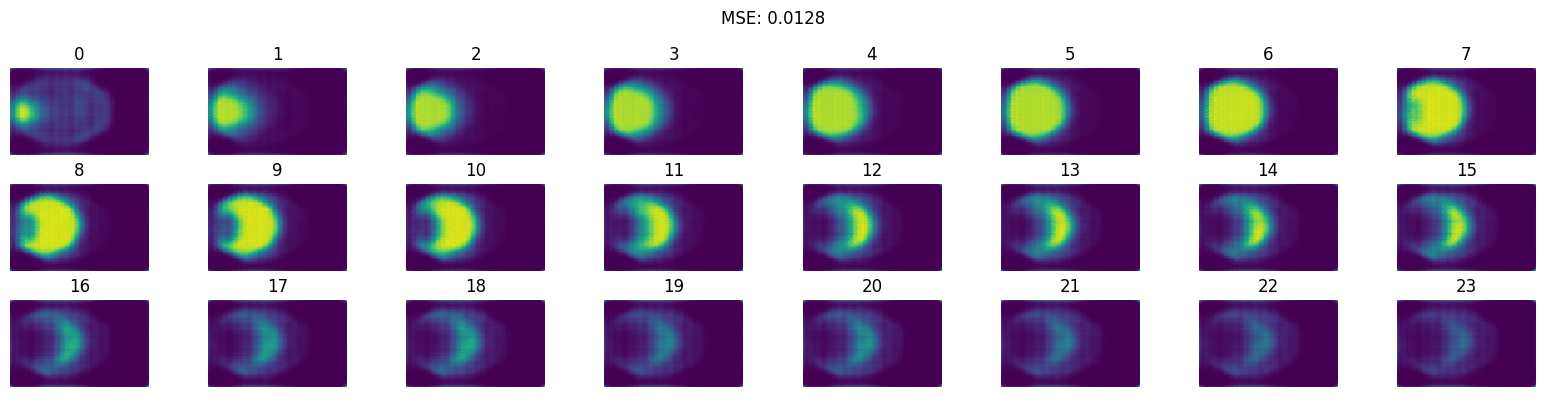

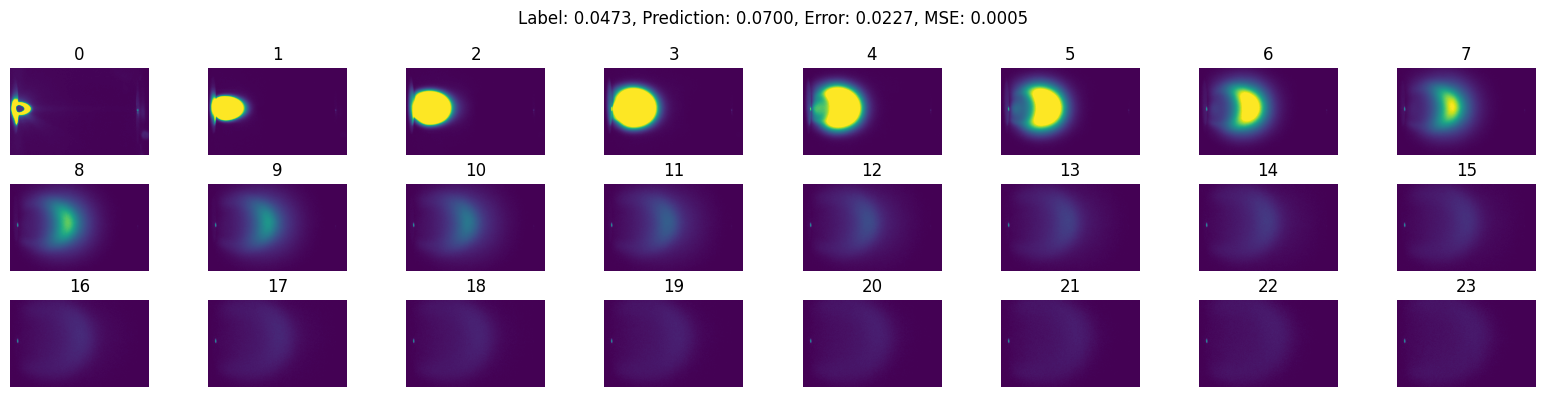

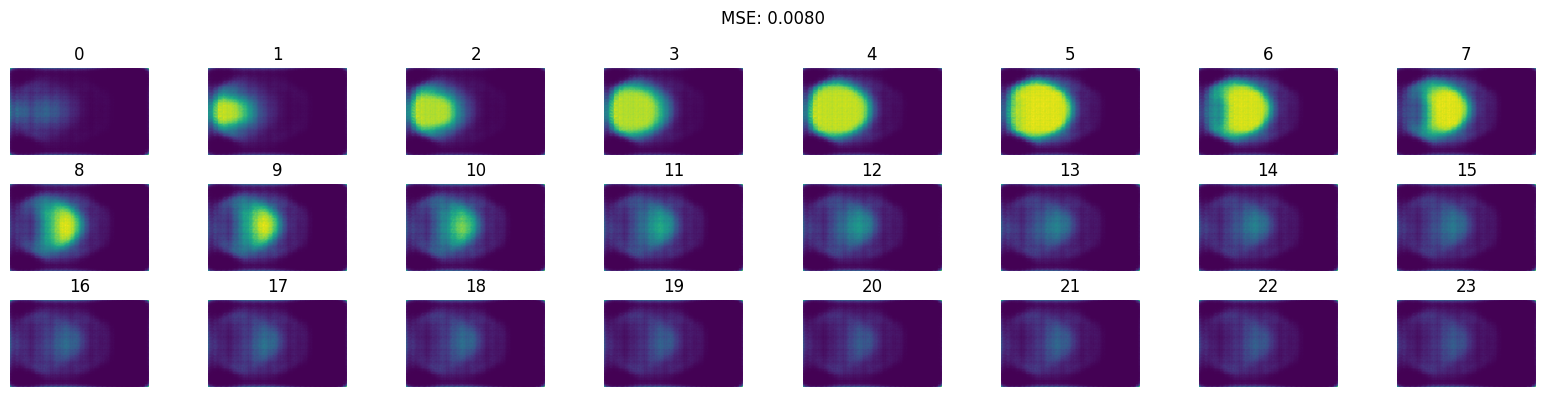

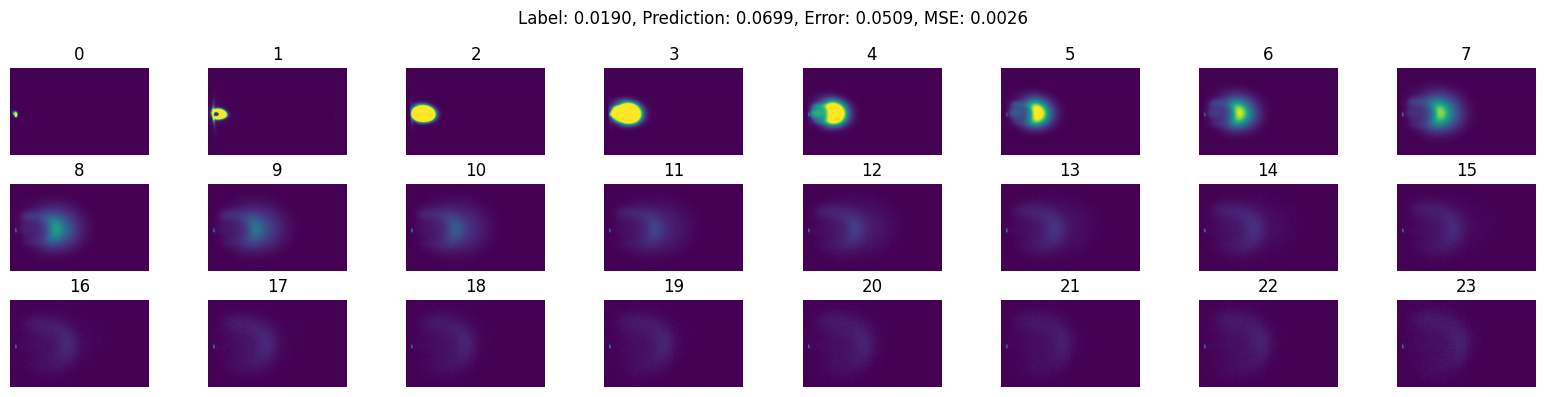

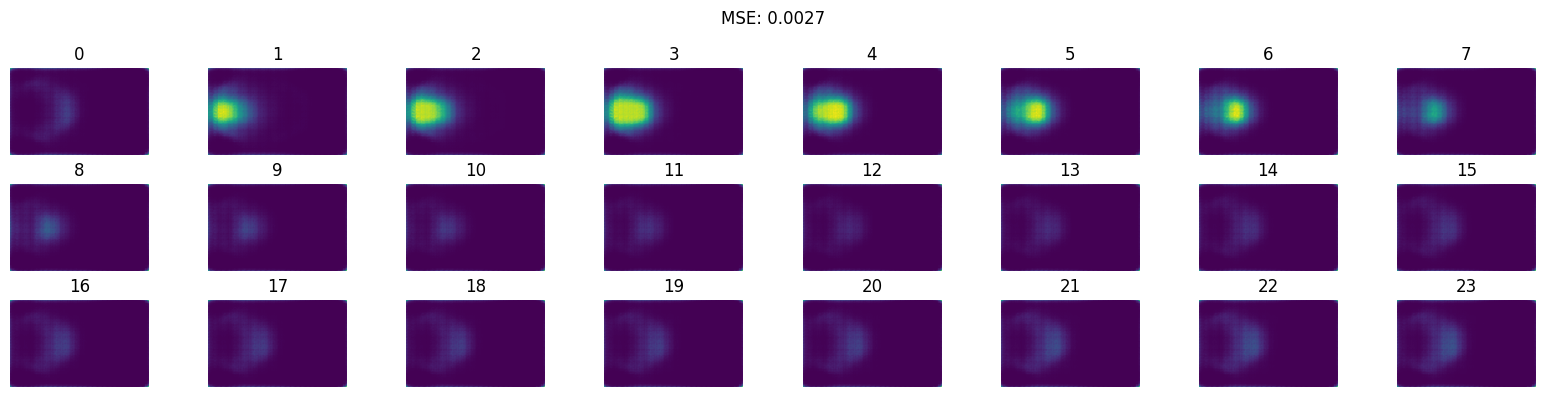

In [9]:
device = torch.device('cuda:6')
loss_func = nn.MSELoss()

batch = next(iter(train_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
gr, reconstructed = model(images)
# images = images.squeeze().cpu().numpy()
# reconstructed = reconstructed.squeeze().cpu().detach().numpy()
print(gr.shape, labels.shape, images.shape, reconstructed.shape)

for i in range(len(images)):
    show_images(images.squeeze().cpu().numpy()[i], title=f'Label: {labels[i].item():.4f}, Prediction: {gr[i].item():.4f}, Error: {gr[i].item()-labels[i].item():.4f}, MSE: {nn.MSELoss()(gr[i], labels[i]).item():.4f}')
    plt.show()
    show_images(reconstructed.squeeze().detach().cpu().numpy()[i], title=f'MSE: {loss_func(reconstructed[i], images[i]).item():.4f}')
    plt.show()

torch.Size([8, 1]) torch.Size([8, 1]) torch.Size([8, 24, 1, 250, 400]) torch.Size([8, 24, 1, 250, 400])


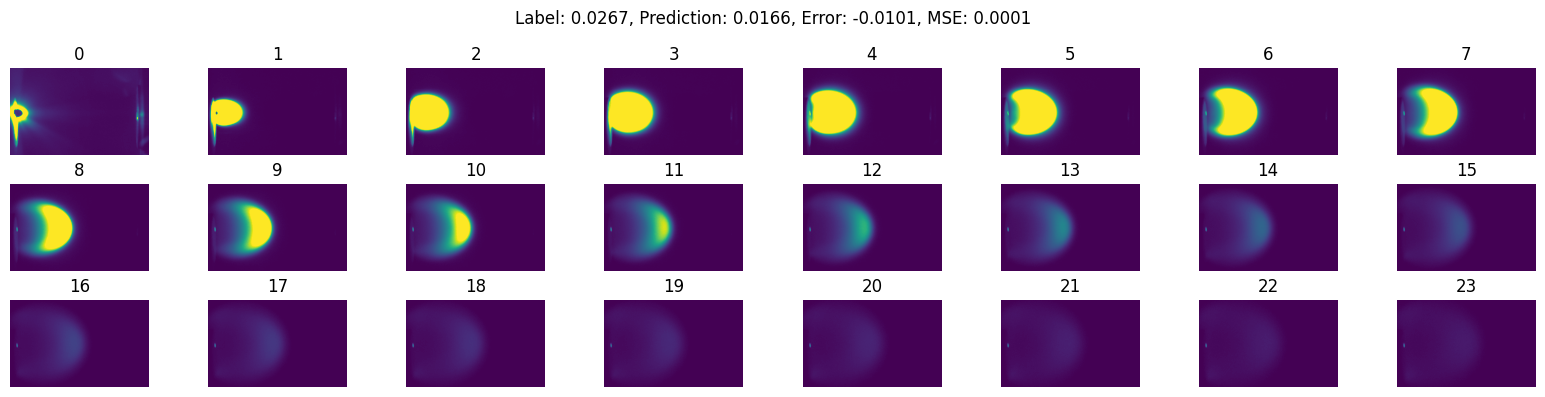

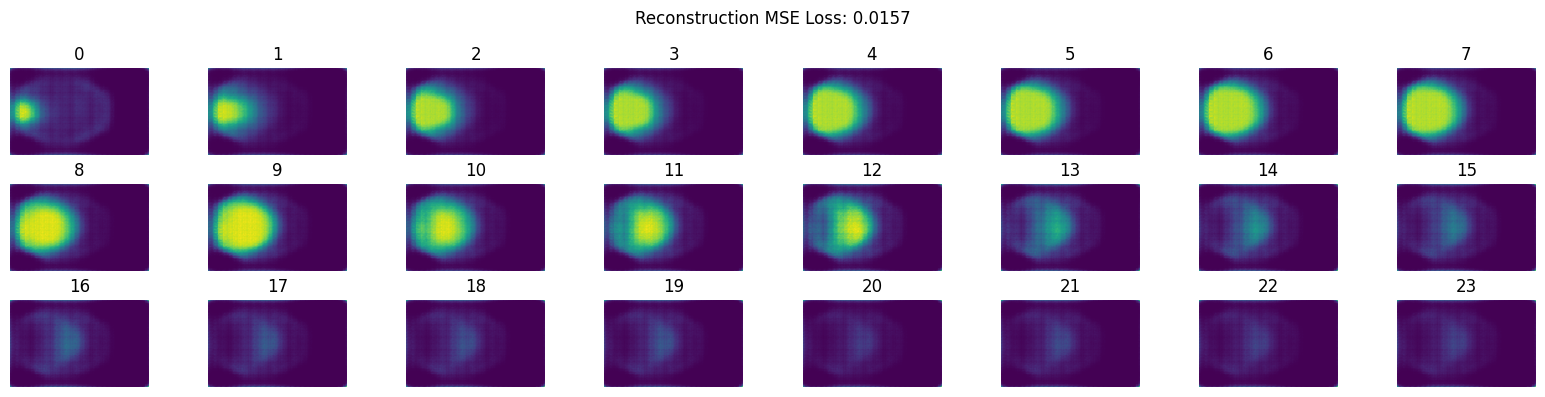

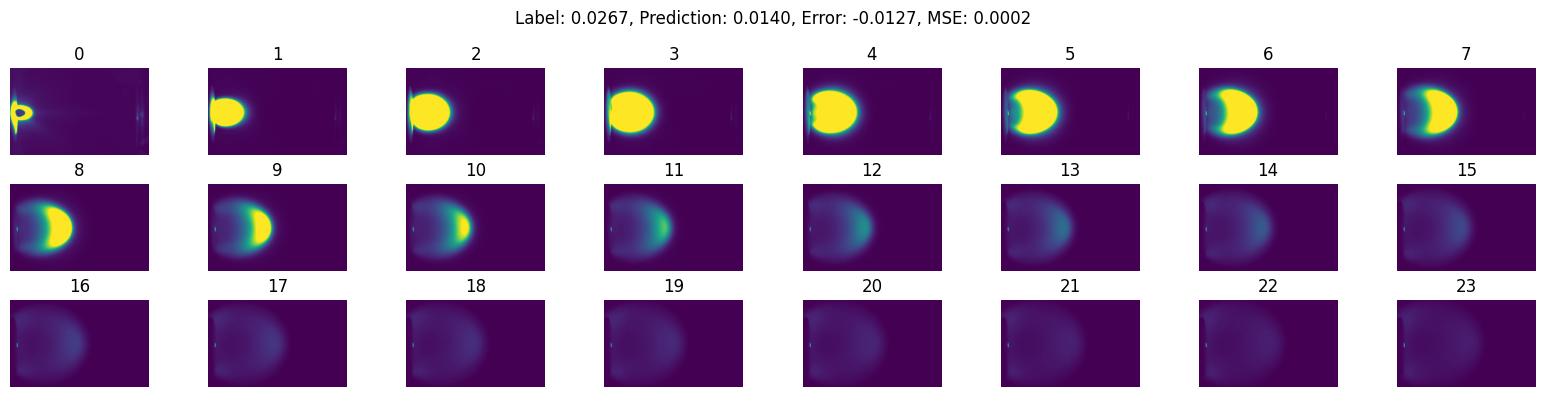

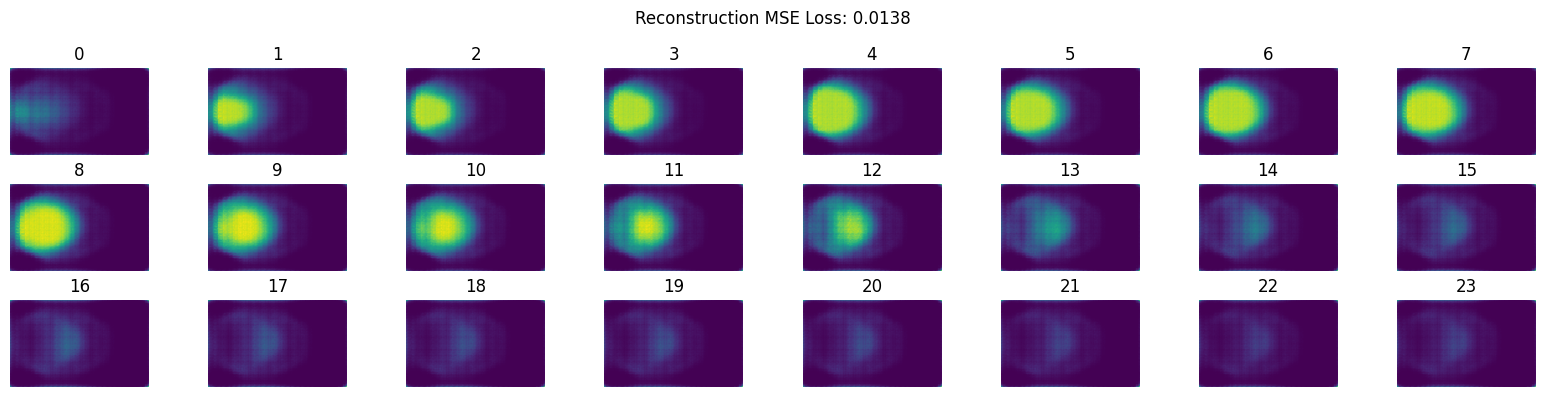

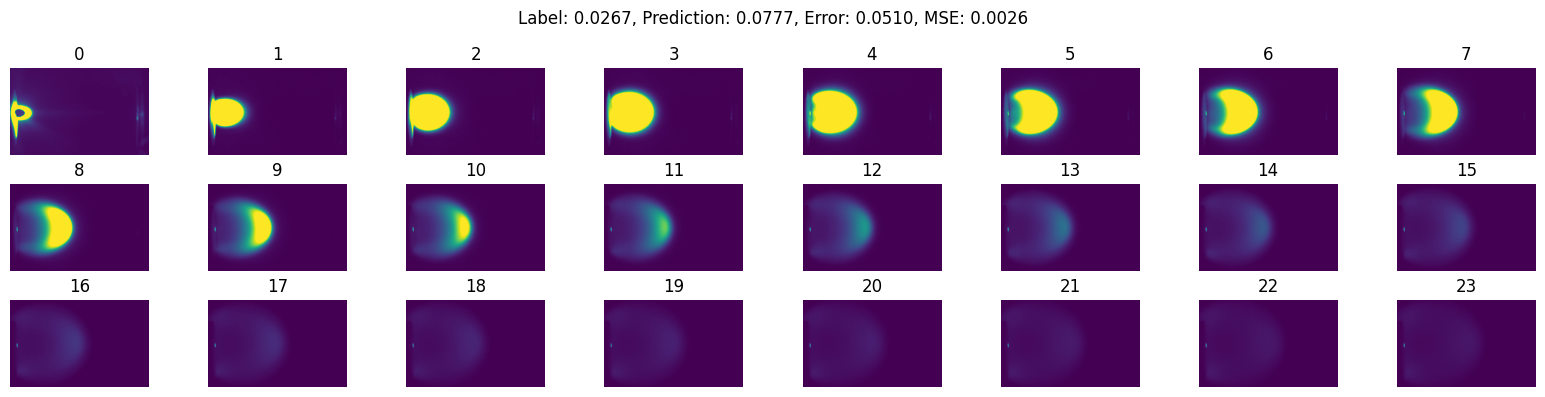

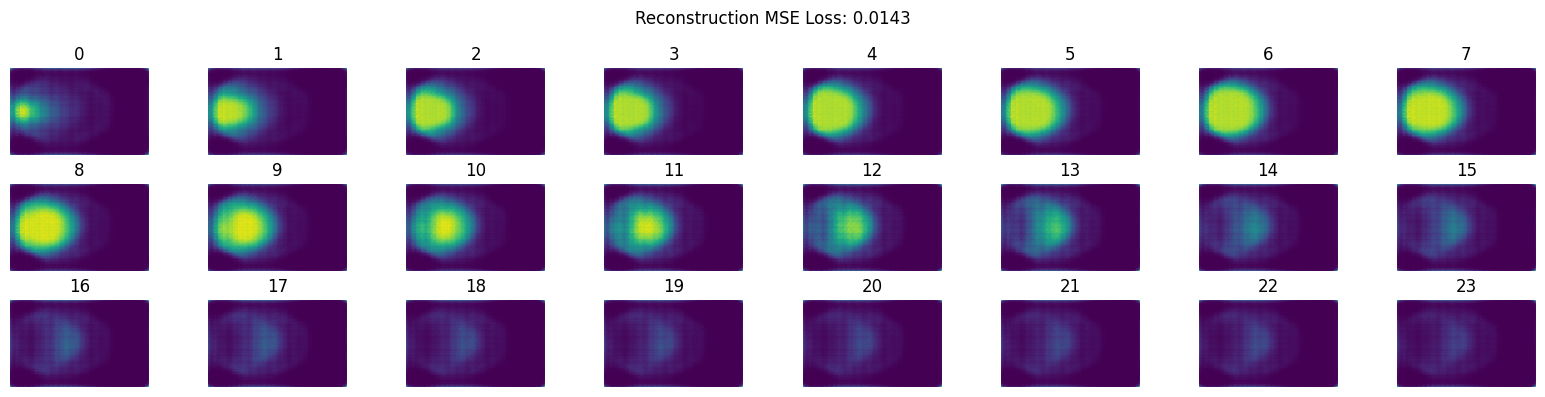

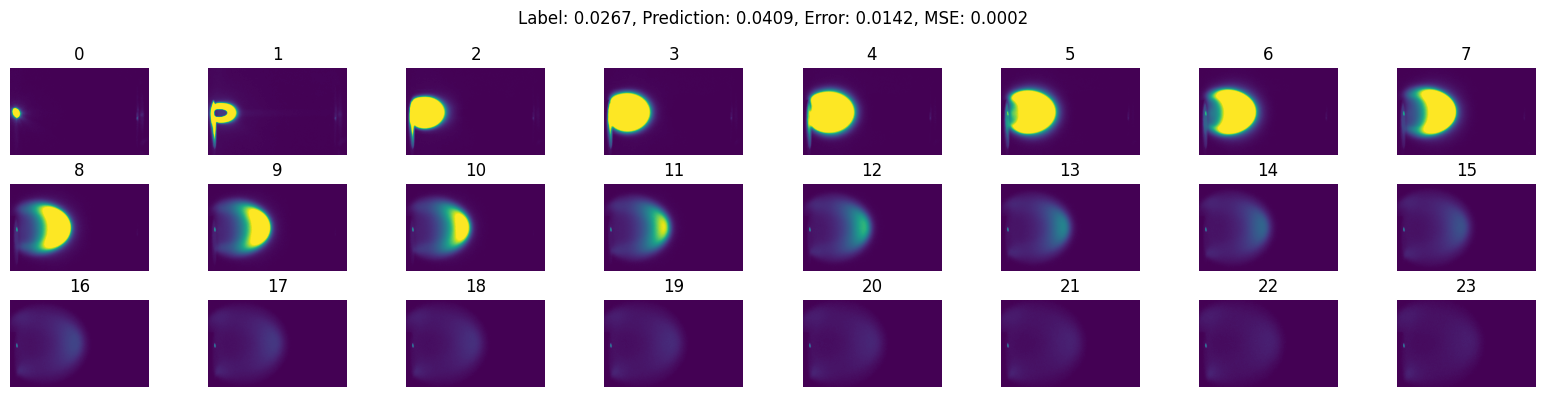

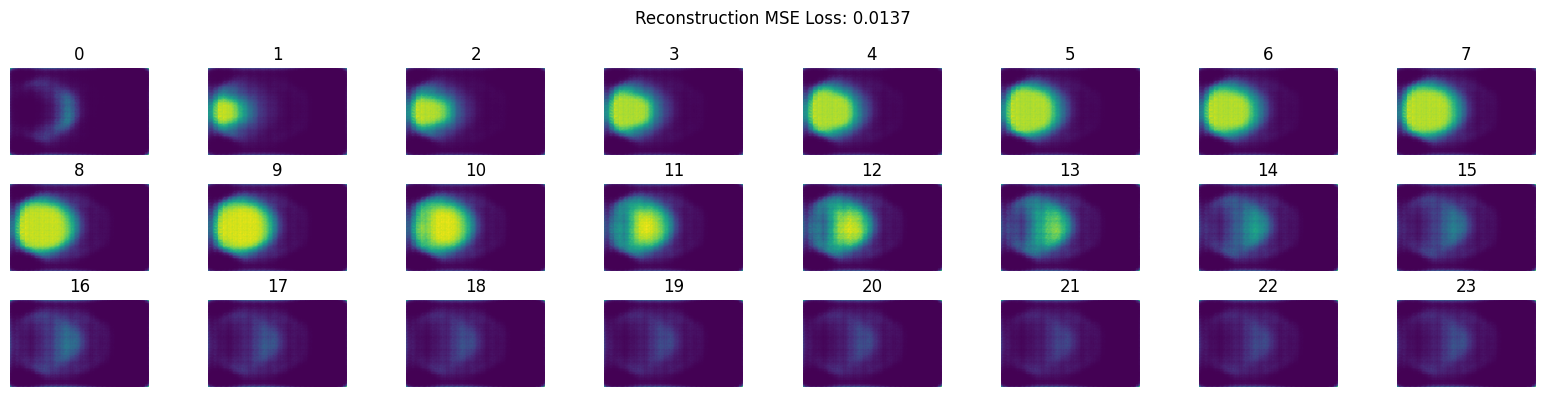

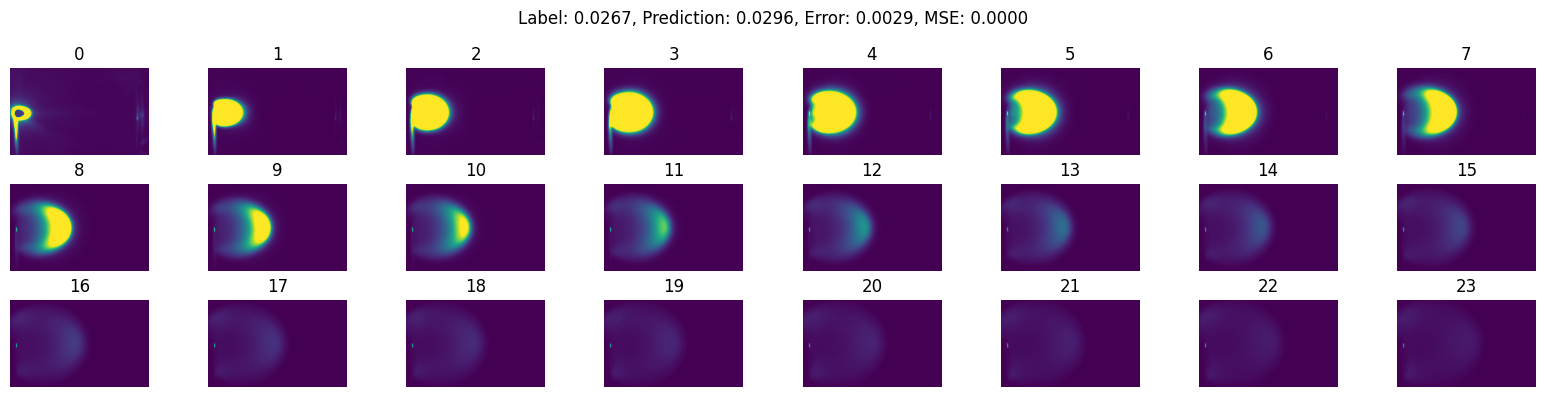

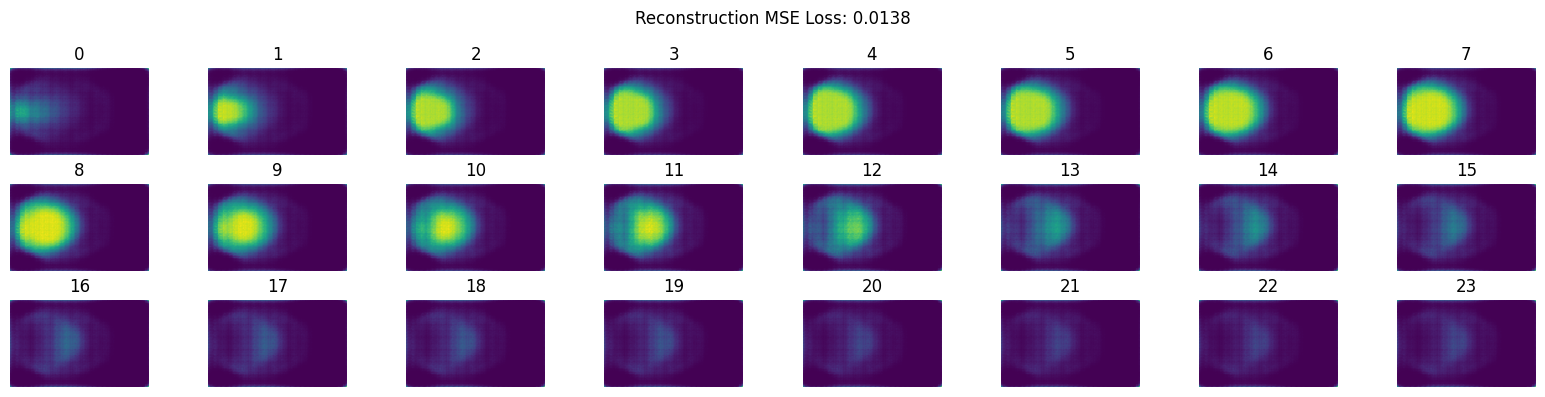

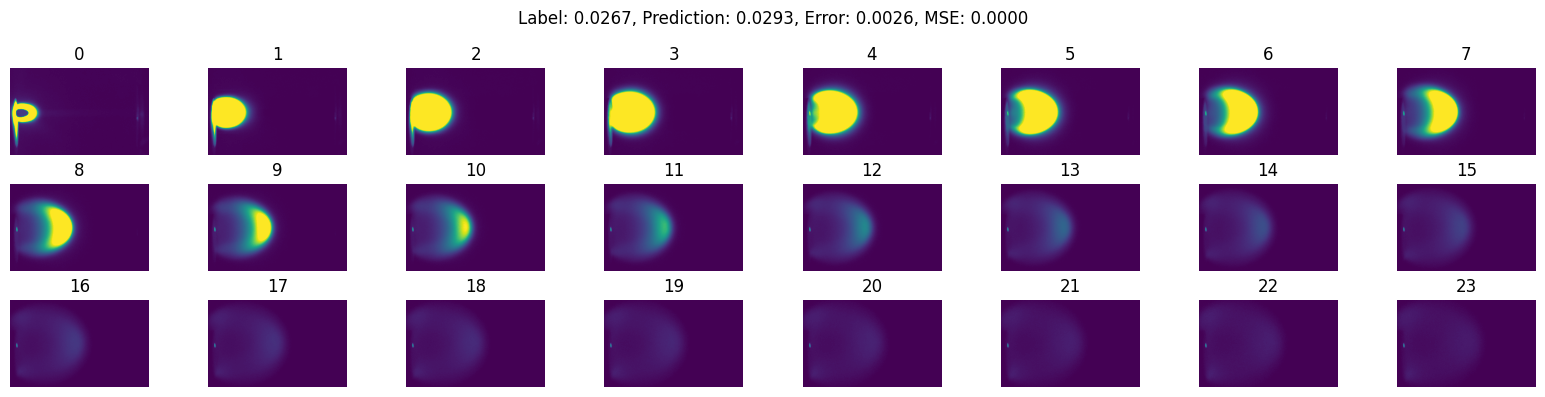

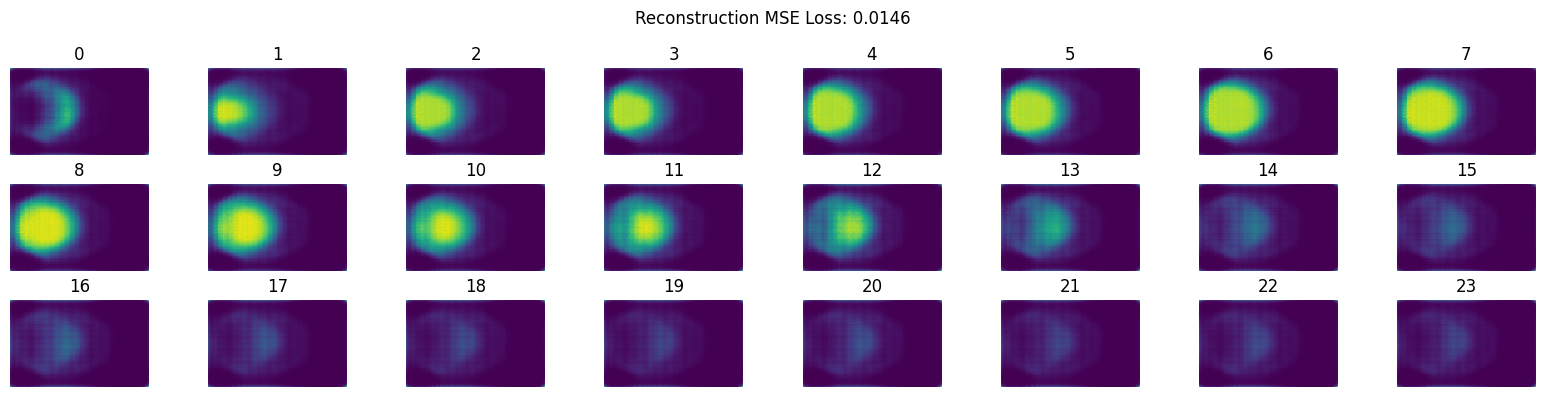

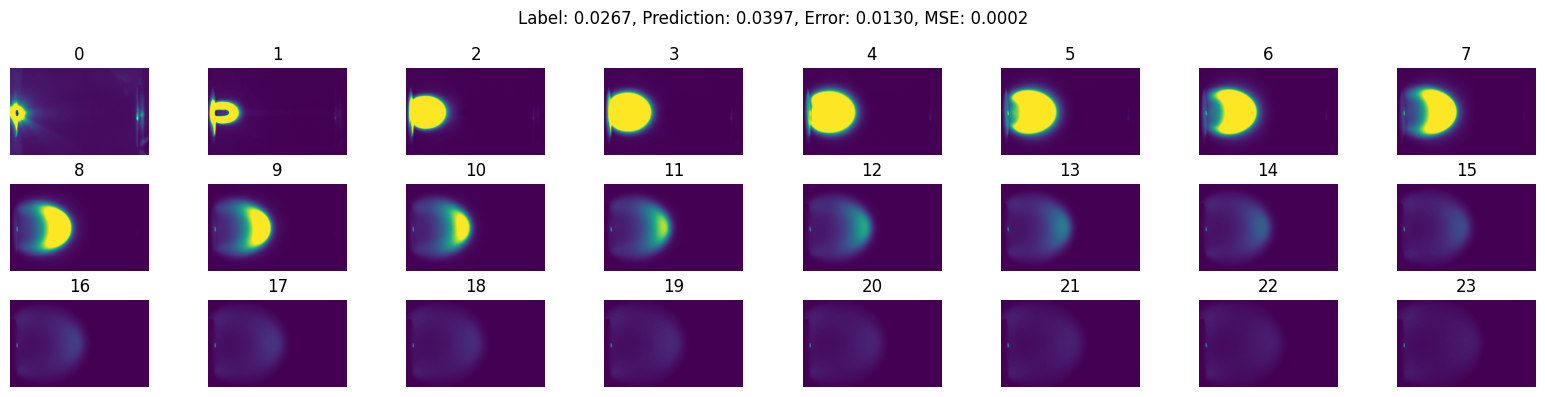

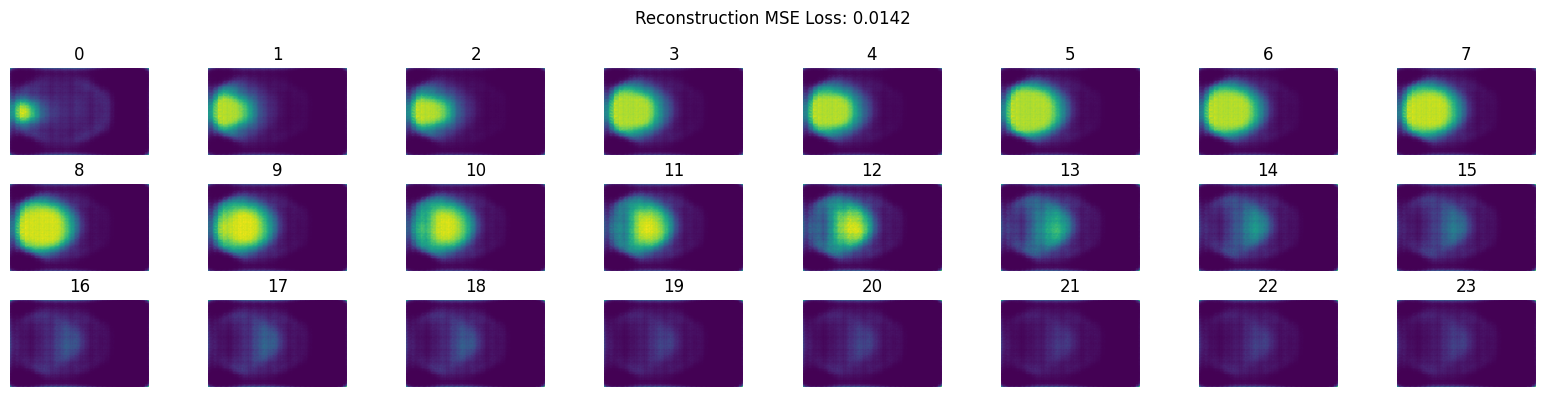

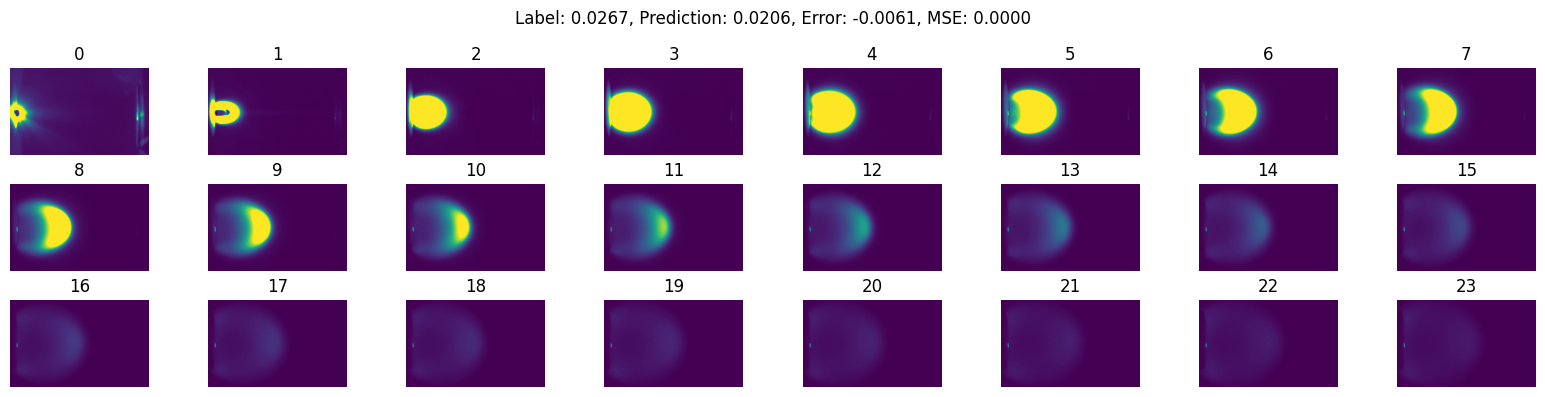

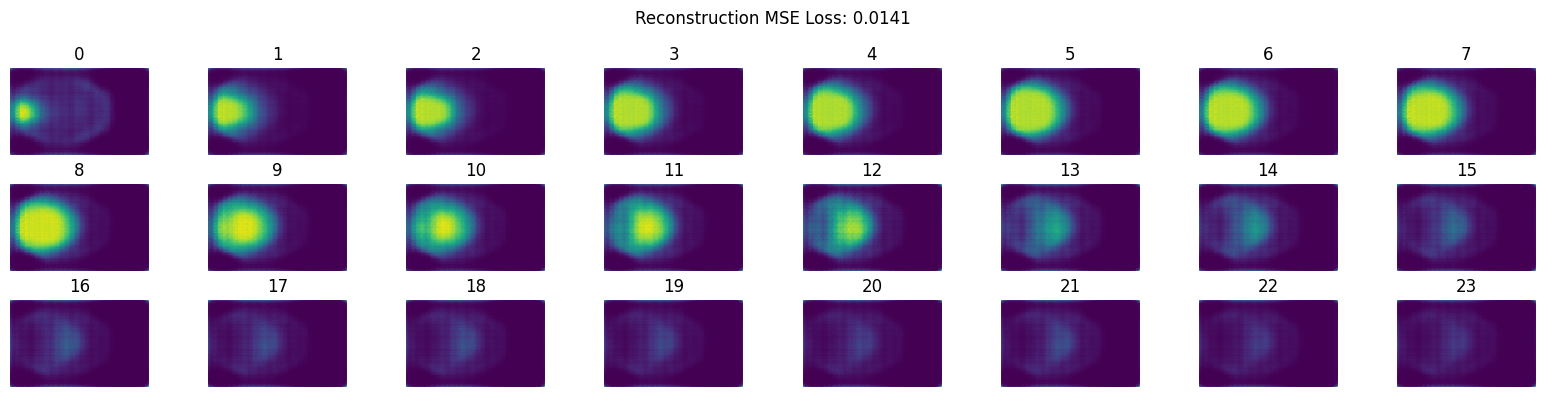

In [10]:
device = torch.device('cuda:6')
loss_func = nn.MSELoss()

batch = next(iter(valid_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
gr, reconstructed = model(images)
# images = images.squeeze().cpu().numpy()
# reconstructed = reconstructed.squeeze().cpu().detach().numpy()
print(gr.shape, labels.shape, images.shape, reconstructed.shape)

for i in range(len(images)):
    show_images(images.squeeze().cpu().numpy()[i], title=f'Label: {labels[i].item():.4f}, Prediction: {gr[i].item():.4f}, Error: {gr[i].item()-labels[i].item():.4f}, MSE: {nn.MSELoss()(gr[i], labels[i]).item():.4f}')
    plt.show()
    show_images(reconstructed.squeeze().detach().cpu().numpy()[i], title=f'Reconstruction MSE Loss: {loss_func(reconstructed[i], images[i]).item():.4f}')
    plt.show()